# LLama2-Like LM
We implement a LLama2-like language model, using a few modifications to the decoder part of the transformer architecture:
- Rotary position embeddings (RoPE): available in Keras library.
- Grouped Query Attention: available in the Keras library, but without RoPE support. We'll add that.
- SwiGLU activation and gating feed-forward network: not available, we'll build a custom layer.
- RMS rather than full layer normalization.  

We then pre-train it on the simplebooks corpus (English only, about 100M tokens) and tune it to respond to instructions.

## Install dependencies

In [1]:
!pip install -U keras keras-hub tensorflow-cpu

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install -U tensorboard-plugin-profile

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install pyarrow fastparquet datasets

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime

We use the Keras library with a JAX backend.

In [5]:
os.environ["KERAS_BACKEND"] = "jax"
# default behavior is to allocate 75% of GPU memory. We need not do that.
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

In [6]:
import keras
# if the GPU supports bfloat16 format and flash attention, uncomment the following 2 lines.
# Note: The T4 GPU in Kaggle and Colab does not.
keras.mixed_precision.set_global_policy("mixed_bfloat16")
keras.config.enable_flash_attention()
import keras_hub

/home/gimarchetti/.local/lib/python3.10/site-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(
2025-05-25 06:50:16.734968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748155816.749777  827394 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748155816.754199  827394 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748155816.768613  8273

In [7]:
import json
import re
import string
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

Tensorflow data is still useful for building a data pre-processing pipeline, even if we do not use Tensorflow as the main computation framework.

In [8]:
import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

In [9]:
from keras import layers, models, losses, callbacks, ops, Layer
from keras.layers import Dense, Layer, Dropout,  RMSNormalization, LayerNormalization, Multiply
from keras.ops import softmax, silu

In [10]:
from keras_hub.layers import RotaryEmbedding

## Set Configuration

In [11]:
gpus=keras.distribution.list_devices()
num_gpus = len(gpus)

print("Num GPUs Available: ", num_gpus)

Num GPUs Available:  8


**Note:** The number of attention heads and blocks must be a multiple of the number of GPUs

In [12]:
VOCAB_SIZE = 5000 # 50000 is the size of the vocabulary for gpt2 on common corpus. Simplebooks is smaller
MAX_LEN = 1024 # the maximum length of the input sequences,
EMBEDDING_DIM = 768 # the dimension of the word embeddings
N_HEADS = 8 #  the number of attention heads
N_KV_HEADS= 8 # N_HEADS//2 # KV heads in GQA , 1 per GPU
NUM_BLOCKS = 8 # Number of transformer blocks 12 in gpt2, 3 in gpt nano
# The hidden dimension of the feed-forward network in the FF block = 4 * embedding with ReLU activation,
# 8/3 * embedding with SwiGLU to keep n. of computations constant
FEED_FORWARD_DIM = int(EMBEDDING_DIM * 8/3)
VALIDATION_SPLIT = 0.2 # the fraction of data to be used for validation
SEED = 42 # the random seed for reproducibility

In [13]:
MIN_STRING_LEN = 256  # Strings shorter than this will be discarded
SEQ_LEN = 512 # 512  # Length of training sequences, in tokens, aka the CONTEXT

In [14]:
BATCH_SIZE_PER_GPU=64 #@param {"type":"integer"}
BATCH_SIZE = BATCH_SIZE_PER_GPU * num_gpus

## Data ingestion and preprocessing

In [15]:
BASE_DIR="./working" #@param {"type":"string"}

In [16]:
keras.utils.get_file(
    origin="https://dldata-public.s3.us-east-2.amazonaws.com/simplebooks.zip",
    extract=True,
    cache_subdir=BASE_DIR+"/keras/",
)


'/home/gimarchetti/.keras/./working/keras/simplebooks.zip'

In [17]:
dir = BASE_DIR+"/keras/simplebooks.zip/simplebooks/"

In [18]:
# Load simplebooks-92 train set and filter out short lines.
raw_train_ds = (
    tf_data.TextLineDataset(dir + "simplebooks-92-raw/train.txt")
    .filter(lambda x: tf_strings.length(x) > MIN_STRING_LEN)
    .batch(BATCH_SIZE, drop_remainder=True)
    .shuffle(buffer_size=256)
)

# Load simplebooks-92 validation set and filter out short lines.
raw_val_ds = (
    tf_data.TextLineDataset(dir + "simplebooks-92-raw/valid.txt")
    .filter(lambda x: tf_strings.length(x) > MIN_STRING_LEN)
    .batch(BATCH_SIZE, drop_remainder=True)
)

2025-05-25 06:50:51.078417: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [19]:
raw_val_ds

<_BatchDataset element_spec=TensorSpec(shape=(512,), dtype=tf.string, name=None)>

In [20]:
for element in raw_val_ds.take(1):
    print(element)

tf.Tensor(
[b'"I am glad of it," said a woolly Lamb on Wheels, who stood on the floor, just under the edge of the toy counter. She was rather too large to be up among the smaller toys. "Yes, I am glad of it," went on the Lamb. "I have kept still all day, and now I have something to tell you all, my friends."'
 b'For it was one of the rules of Toyland, as you know, that none of the folk who lived there could do anything while human eyes were watching them. The Dolls, Soldiers, Clowns, Rocking Horses, Lambs were not able to move, talk, or make believe come to life if a boy or a girl or any one at all looked at them.'
 b'"Yes, you are always ready to jump out of your box as soon as the cover is taken off," remarked the Lamb on Wheels. "But the rest of us are not such high kickers as you are. I cannot jump at all. I can only run around on my wheels, just as the White Rocking Horse, who used to live here, could only go on his rockers."'
 b'"Do you mean the Sawdust Doll who used to live here

In [21]:
#if there is no val_ds
#raw_train_ds, raw_val_ds= keras.utils.split_dataset(raw_train_ds, 0.8)

## Tokenization

### EITHER train and save a vocabulary

In [22]:
# Train tokenizer vocabulary
#vocab = keras_hub.tokenizers.compute_word_piece_vocabulary(
#    raw_train_ds,
#    vocabulary_size=VOCAB_SIZE,
#    lowercase=True,
#    reserved_tokens=["[PAD]", "[UNK]", "[BOS]"],
#)

In [23]:
#import pickle
#with open(BASE_DIR+'/simplebooks_vocab.pkl', 'wb') as f:
#    pickle.dump(vocab, f)

### OR retrieve vocabulary

In [24]:
#insert code to save and retrieve tokenizer
import pickle
with open('./working/simplebooks_vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

In [25]:
vocab[100:120]

['that',
 'it',
 'had',
 '##s',
 'his',
 'as',
 'for',
 'with',
 'they',
 'on',
 'but',
 'her',
 'at',
 'she',
 'were',
 'not',
 'you',
 'be',
 'him',
 'all']

### Tokenize

In [26]:
tokenizer = keras_hub.tokenizers.WordPieceTokenizer(
    vocabulary=vocab,
    sequence_length=SEQ_LEN,
    lowercase=True,
)

In [27]:
# packer adds a start token
start_packer = keras_hub.layers.StartEndPacker(
    sequence_length=SEQ_LEN,
    start_value=tokenizer.token_to_id("[BOS]"),
)

def preprocess(inputs):
    outputs = tokenizer(inputs)
    features = start_packer(outputs)
    labels = outputs
    return features, labels


# Tokenize and split into train and label sequences.
train_ds = raw_train_ds.map(preprocess, num_parallel_calls=tf_data.AUTOTUNE).prefetch(
    tf_data.AUTOTUNE
)
val_ds = raw_val_ds.map(preprocess, num_parallel_calls=tf_data.AUTOTUNE).prefetch(
    tf_data.AUTOTUNE
)

## Define model

## LLama additions

### Feed-Forward Layer with SwiGLU
SwiGLU Layer, i.e. a Dense layer with SwiGLU activation following the formulation per original paper:  
FFNSwiGLU=(Swish(xW)*xV)W2

In [28]:
## This replaces the first Dense layer of the FF block
@keras.saving.register_keras_serializable()
class FFNSwiGLU(Layer):
    def __init__(self, intermediate_dim, **kwargs):
        super(FFNSwiGLU, self).__init__(**kwargs)
        self.intermediate_dim = intermediate_dim

    def build(self, input_shape):
        last_dim = input_shape[-1]
        self.W = self.add_weight(shape=(last_dim, self.intermediate_dim), initializer='glorot_uniform', trainable=True, name='W')
        self.V = self.add_weight(shape=(last_dim, self.intermediate_dim), initializer='glorot_uniform', trainable=True, name='V')
        self.W2 = self.add_weight(shape=(self.intermediate_dim,), initializer='glorot_uniform', trainable=True, name='W2')
        super(FFNSwiGLU, self).build(input_shape)

    def call(self, inputs):
        gate = silu(inputs @ self.W)
        return (gate * (inputs @ self.V)) * self.W2

    def get_config(self):
        config = super(FFNSwiGLU, self).get_config()
        config.update({'intermediate_dim': self.intermediate_dim})
        return config

In [29]:
# This replaces the first Dense layer of the FF block
@keras.saving.register_keras_serializable()
class FFNSwiGLU2(Layer):
    def __init__(self, intermediate_dim, **kwargs):
        super(FFNSwiGLU2, self).__init__(**kwargs)
        self.intermediate_dim = intermediate_dim

    def build(self, input_shape):
        last_dim = input_shape[-1]
        self.gate = Dense(self.intermediate_dim, activation="silu", use_bias=False, name="swiglu_gate")
        self.linear = Dense(self.intermediate_dim, use_bias=False, name="swiglu_linear")
        self.multiply= Multiply(name="swiglu_out")

    def call(self, inputs):
        gated = self.gate(inputs)
        linear_out=self.linear(inputs)
        #swiglu_out=self.multiply([gated, linear_out])
        return gated*linear_out

    def get_config(self):
        config = super(FFNSwiGLU2, self).get_config()
        config.update({'intermediate_dim': self.intermediate_dim})
        return config



### Grouped Query Attention - the "formal" implementation
In the RoPE paper, RoPE is applied to the queries Q and keys K, NOT the embeddings. This requires a reworking of the default Grouped Query Attention layer.   



In [30]:
import math

from keras.src import constraints
from keras.src import initializers
from keras.src import ops
from keras.src import regularizers
from keras.src.api_export import keras_export
from keras.src.backend.config import is_flash_attention_enabled
from keras.src.layers.activations.softmax import Softmax
from keras.src.layers.core.einsum_dense import EinsumDense
from keras.src.layers.layer import Layer
from keras.src.layers.regularization.dropout import Dropout


The following was adapted from Keras source code.

In [31]:
@keras.saving.register_keras_serializable()
class GQAwithRoPE(Layer):
    """Grouped Query Attention layer.

    This is an implementation of grouped-query attention introduced by
    [Ainslie et al., 2023](https://arxiv.org/abs/2305.13245). Here
    `num_key_value_heads` denotes number of groups, setting
    `num_key_value_heads` to 1 is equivalent to multi-query attention, and
    when `num_key_value_heads` is equal to `num_query_heads` it is equivalent
    to multi-head attention.

    This layer first projects `query`, `key`, and `value` tensors. Then, `key`
    and `value` are repeated to match the number of heads of `query`.

    Then, the `query` is scaled and dot-producted with `key` tensors. These are
    softmaxed to obtain attention probabilities. The value tensors are then
    interpolated by these probabilities and concatenated back to a single
    tensor.

    Args:
        head_dim: Size of each attention head.
        num_query_heads: Number of query attention heads.
        num_key_value_heads: Number of key and value attention heads.
        dropout: Dropout probability.
        use_bias: Boolean, whether the dense layers use bias vectors/matrices.
        flash_attention: If `None`, the layer attempts to use flash
            attention for faster and more memory-efficient attention
            computations when possible. This behavior can be configured using
            `keras.config.enable_flash_attention()` or
            `keras.config.disable_flash_attention()`.
        kernel_initializer: Initializer for dense layer kernels.
        bias_initializer: Initializer for dense layer biases.
        kernel_regularizer: Regularizer for dense layer kernels.
        bias_regularizer: Regularizer for dense layer biases.
        activity_regularizer: Regularizer for dense layer activity.
        kernel_constraint: Constraint for dense layer kernels.
        bias_constraint: Constraint for dense layer kernels.
        seed: Optional integer to seed the dropout layer.

    Call arguments:
        query: Query tensor of shape `(batch_dim, target_seq_len, feature_dim)`,
            where `batch_dim` is batch size, `target_seq_len` is the length of
            target sequence, and `feature_dim` is dimension of feature.
        value: Value tensor of shape `(batch_dim, source_seq_len, feature_dim)`,
            where `batch_dim` is batch size, `source_seq_len` is the length of
            source sequence, and `feature_dim` is dimension of feature.
        key: Optional key tensor of shape
            `(batch_dim, source_seq_len, feature_dim)`. If not given, will use
            `value` for both `key` and `value`, which is most common case.
        attention_mask: A boolean mask of shape
            `(batch_dim, target_seq_len, source_seq_len)`, that prevents
            attention to certain positions. The boolean mask specifies which
            query elements can attend to which key elements, where 1 indicates
            attention and 0 indicates no attention. Broadcasting can happen for
            the missing batch dimensions and the head dimension.
        return_attention_scores: A boolean to indicate whether the output
            should be `(attention_output, attention_scores)` if `True`, or
            `attention_output` if `False`. Defaults to `False`.
        training: Python boolean indicating whether the layer should behave in
            training mode (adding dropout) or in inference mode (no dropout).
            Will go with either using the training mode of the parent
            layer/model or `False` (inference) if there is no parent layer.
        use_causal_mask: A boolean to indicate whether to apply a causal mask to
            prevent tokens from attending to future tokens (e.g., used in a
            decoder Transformer).

    Returns:
        attention_output: Result of the computation, of shape
            `(batch_dim, target_seq_len, feature_dim)`, where `target_seq_len`
            is for target sequence length and `feature_dim` is the query input
            last dim.
        attention_scores: (Optional) attention coefficients of shape
            `(batch_dim, num_query_heads, target_seq_len, source_seq_len)`.
    """

    def __init__(
        self,
        head_dim,
        num_query_heads,
        num_key_value_heads,
        dropout=0.0,
        use_bias=True,
        flash_attention=None,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        seed=None,
        use_rope=True,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.head_dim = head_dim
        self.num_query_heads = num_query_heads
        self.num_key_value_heads = num_key_value_heads
        if num_query_heads % num_key_value_heads != 0:
            raise ValueError(
                "`num_query_heads` must be divisible by `num_key_value_heads`."
            )
        self.num_repeats = num_query_heads // num_key_value_heads
        self.dropout = dropout
        self.use_bias = use_bias
        self._flash_attention = flash_attention or is_flash_attention_enabled()
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.seed = seed
        self.use_rope = use_rope

        self._inverse_sqrt_head_dim = 1.0 / math.sqrt(float(self.head_dim))
        self._return_attention_scores = False

        # Check for flash attention constraints
        if self._flash_attention and self.dropout > 0.0:
            raise ValueError(
                "Dropout is not supported when flash attention is enabled. "
                "Please set dropout to 0.0 to use flash attention."
            )

    def build(
        self,
        query_shape,
        value_shape,
        key_shape=None,
    ):
        # Einsum variables:
        # b = batch size
        # q = query length
        # k = key/value length
        # m = model dim
        # u = num query heads
        # v = num key/value heads
        # h = head dim
        key_shape = value_shape if key_shape is None else key_shape
        self.feature_dim = query_shape[-1]
        self._query_dense = EinsumDense(
            "bqm,muh->bquh",
            output_shape=(None, self.num_query_heads, self.head_dim),
            bias_axes="uh" if self.use_bias else None,
            name="query",
            **self._get_common_kwargs_for_sublayer(),
        )
        self._query_dense.build(query_shape)

        self._key_dense = EinsumDense(
            "bkm,mvh->bkvh",
            output_shape=(None, self.num_key_value_heads, self.head_dim),
            bias_axes="vh" if self.use_bias else None,
            name="key",
            **self._get_common_kwargs_for_sublayer(),
        )
        self._key_dense.build(key_shape)

        self._value_dense = EinsumDense(
            "bkm,mvh->bkvh",
            output_shape=(None, self.num_key_value_heads, self.head_dim),
            bias_axes="vh" if self.use_bias else None,
            name="value",
            **self._get_common_kwargs_for_sublayer(),
        )
        self._value_dense.build(value_shape)

        self._softmax = Softmax(axis=-1, dtype=self.dtype_policy)
        self._dropout_layer = Dropout(
            rate=self.dropout, dtype=self.dtype_policy, seed=self.seed
        )

        self._dot_product_equation = "bquh,bkuh->buqk"
        self._combine_equation = "buqk,bkuh->bquh"

        self._output_dense = EinsumDense(
            "bquh,uhm->bqm",
            output_shape=(None, self.feature_dim),
            bias_axes="m" if self.use_bias else None,
            name="attention_output",
            **self._get_common_kwargs_for_sublayer(),
        )
        self._output_dense.build(
            (None, None, self.num_query_heads, self.head_dim)
        )

        self._rope=RotaryEmbedding()

        self.built = True

    def _get_common_kwargs_for_sublayer(self):
        common_kwargs = dict(
            kernel_regularizer=self.kernel_regularizer,
            bias_regularizer=self.bias_regularizer,
            activity_regularizer=self.activity_regularizer,
            kernel_constraint=self.kernel_constraint,
            bias_constraint=self.bias_constraint,
            dtype=self.dtype_policy,
        )
        # Create new clone of kernel/bias initializer, so that we don't reuse
        # the initializer instance, which could lead to same init value since
        # initializer is stateless.
        kernel_initializer = self.kernel_initializer.__class__.from_config(
            self.kernel_initializer.get_config()
        )
        bias_initializer = self.bias_initializer.__class__.from_config(
            self.bias_initializer.get_config()
        )
        common_kwargs["kernel_initializer"] = kernel_initializer
        common_kwargs["bias_initializer"] = bias_initializer
        return common_kwargs

    def call(
        self,
        query,
        value,
        key=None,
        query_mask=None,
        value_mask=None,
        key_mask=None,
        attention_mask=None,
        return_attention_scores=False,
        training=None,
        use_causal_mask=False,
    ):
        self._return_attention_scores = return_attention_scores
        if key is None:
            key = value

        attention_mask = self._compute_attention_mask(
            query,
            value,
            query_mask=query_mask,
            value_mask=value_mask,
            key_mask=key_mask,
            attention_mask=attention_mask,
            use_causal_mask=use_causal_mask,
        )

        query = self._query_dense(query)
        key = self._key_dense(key)
        value = self._value_dense(value)

        if self.use_rope:
          query = self._rope(query)
          key = self._rope(key)


        key = ops.repeat(
            key, self.num_repeats, axis=2
        )  # (batch_dim, source_seq_len, query_heads, head_dim)
        value = ops.repeat(
            value, self.num_repeats, axis=2
        )  # (batch_dim, source_seq_len, query_heads, head_dim)

        output, scores = self._compute_attention(
            query,
            key,
            value,
            attention_mask=attention_mask,
            training=training,
        )

        output = self._output_dense(
            output
        )  # (batch_dim, target_seq_len, feature_dim)

        if return_attention_scores:
            return output, scores
        return output

    def _compute_attention_mask(
        self,
        query,
        value,
        query_mask=None,
        value_mask=None,
        key_mask=None,
        attention_mask=None,
        use_causal_mask=False,
    ):
        """Computes the attention mask, using the Keras masks of the inputs.

        * The `query`'s mask is reshaped from [B, T] to [B, T, 1].
        * The `value`'s mask is reshaped from [B, S] to [B, 1, S].
        * The `key`'s mask is reshaped from [B, S] to [B, 1, S]. The `key`'s
          mask is ignored if `key` is `None` or if `key is value`.
        * If `use_causal_mask=True`, then the causal mask is computed. Its shape
          is [1, T, S].

        All defined masks are merged using a logical AND operation (`&`).

        In general, if the `query` and `value` are masked, then there is no need
        to define the `attention_mask`.

        Args:
            query: Projected query tensor of shape `(B, T, N, key_dim)`.
            key: Projected key tensor of shape `(B, T, N, key_dim)`.
            value: Projected value tensor of shape `(B, T, N, value_dim)`.
            attention_mask: a boolean mask of shape `(B, T, S)`, that prevents
                attention to certain positions.
            use_causal_mask: A boolean to indicate whether to apply a causal
                mask to prevent tokens from attending to future tokens (e.g.,
                used in a decoder Transformer).

        Returns:
            attention_mask: a boolean mask of shape `(B, T, S)`, that prevents
                attention to certain positions, based on the Keras masks of the
                `query`, `key`, `value`, and `attention_mask` tensors, and the
                causal mask if `use_causal_mask=True`.
        """
        auto_mask = None
        if query_mask is not None:
            query_mask = ops.cast(query_mask, "bool")  # defensive casting
            # B = batch size, T = max query length
            auto_mask = ops.expand_dims(query_mask, -1)  # shape is [B, T, 1]
        if value_mask is not None:
            value_mask = ops.cast(value_mask, "bool")  # defensive casting
            # B = batch size, S == max value length
            mask = ops.expand_dims(value_mask, -2)  # shape is [B, 1, S]
            auto_mask = mask if auto_mask is None else auto_mask & mask
        if key_mask is not None:
            key_mask = ops.cast(key_mask, "bool")  # defensive casting
            # B == batch size, S == max key length == max value length
            mask = ops.expand_dims(key_mask, -2)  # shape is [B, 1, S]
            auto_mask = mask if auto_mask is None else auto_mask & mask
        if use_causal_mask:
            # the shape of the causal mask is [1, T, S]
            mask = self._compute_causal_mask(query, value)
            auto_mask = mask if auto_mask is None else auto_mask & mask
        if auto_mask is not None:
            # merge attention_mask & automatic mask, to shape [B, T, S]
            attention_mask = (
                auto_mask
                if attention_mask is None
                else ops.cast(attention_mask, bool) & auto_mask
            )
        return attention_mask

    def _compute_causal_mask(self, query, value=None):
        """Computes a causal mask (e.g., for masked self-attention layers).

        For example, if query and value both contain sequences of length 4,
        this function returns a boolean tensor equal to:

        ```
        [[[True,  False, False, False],
          [True,  True,  False, False],
          [True,  True,  True,  False],
          [True,  True,  True,  True]]]
        ```

        Args:
            query: query tensor of shape `(B, T, ...)`.
            value: value tensor of shape `(B, S, ...)` (optional, defaults to
                query).

        Returns:
            mask: a boolean tensor of shape `(1, T, S)` containing a lower
                triangular matrix of shape `(T, S)`.
        """
        q_seq_length = ops.shape(query)[1]
        v_seq_length = q_seq_length if value is None else ops.shape(value)[1]
        ones_mask = ops.ones((1, q_seq_length, v_seq_length), dtype="int32")
        row_index = ops.cumsum(ones_mask, axis=-2)
        col_index = ops.cumsum(ones_mask, axis=-1)
        return ops.greater_equal(row_index, col_index)

    def _compute_attention(
        self, query, key, value, attention_mask=None, training=None
    ):
        # Check for flash attention constraints
        if self._flash_attention and self._return_attention_scores:
            raise ValueError(
                "Returning attention scores is not supported when flash "
                "attention is enabled. Please disable flash attention to access"
                " attention scores."
            )

        # Determine whether to use dot-product attention
        use_dot_product_attention = not (
            self.dropout > 0.0
            or self._return_attention_scores
            or (len(query.shape) != 4)
        )

        if use_dot_product_attention:
            if attention_mask is not None:
                # Ensure attention_mask has the correct shape for broadcasting
                # Expected shape: [batch_size, num_heads, query_seq_len,
                # key_seq_len].
                mask_expansion_axis = -1 * 2 - 1
                len_attention_scores_shape = 4  # Only accepts 4D inputs
                for _ in range(
                    len_attention_scores_shape - len(attention_mask.shape)
                ):
                    attention_mask = ops.expand_dims(
                        attention_mask, axis=mask_expansion_axis
                    )
                attention_mask = ops.cast(attention_mask, dtype="bool")
            # Directly compute the attention output using dot-product attention
            attention_output = ops.dot_product_attention(
                query=query,
                key=key,
                value=value,
                bias=None,
                mask=attention_mask,
                scale=self._inverse_sqrt_head_dim,
                is_causal=False,
                flash_attention=self._flash_attention,
            )
            return attention_output, None

        # Default behavior without flash attention, with explicit attention
        # scores
        query = ops.multiply(
            query, ops.cast(self._inverse_sqrt_head_dim, query.dtype)
        )
        # Take the dot product between "query" and "key" to get the raw
        # attention scores.
        scores = ops.einsum(
            self._dot_product_equation, query, key
        )  # (batch_dim, query_heads, target_seq_len, source_seq_len)
        scores = self._masked_softmax(scores, attention_mask=attention_mask)
        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        if self.dropout > 0.0:
            scores_dropout = self._dropout_layer(scores, training=training)
        else:
            scores_dropout = scores
        output = ops.einsum(self._combine_equation, scores_dropout, value)
        return output, scores

    def _masked_softmax(self, scores, attention_mask=None):
        # Normalize the attention scores to probabilities.
        # scores = [B, N, T, S]
        if attention_mask is not None:
            # The expand dim happens starting from the `num_heads` dimension,
            # (<batch_dims>, num_heads, <query_attention_dims,
            # key_attention_dims>)
            mask_expansion_axis = -1 * 2 - 1
            for _ in range(len(scores.shape) - len(attention_mask.shape)):
                attention_mask = ops.expand_dims(
                    attention_mask, axis=mask_expansion_axis
                )
        return self._softmax(scores, mask=attention_mask)

    def compute_output_shape(
        self,
        query_shape,
        value_shape,
        key_shape=None,
    ):
        if key_shape is None:
            key_shape = value_shape

        if query_shape[-1] != value_shape[-1]:
            raise ValueError(
                "The last dimension of `query_shape` and `value_shape` "
                f"must be equal, but are {query_shape[-1]}, {value_shape[-1]}. "
                "Received: query_shape={query_shape}, value_shape={value_shape}"
            )

        if value_shape[1:-1] != key_shape[1:-1]:
            raise ValueError(
                "All dimensions of `value` and `key`, except the last one, "
                f"must be equal. Received: value_shape={value_shape} and "
                f"key_shape={key_shape}"
            )

        return query_shape

    def get_config(self):
        config = {
            "head_dim": self.head_dim,
            "num_query_heads": self.num_query_heads,
            "num_key_value_heads": self.num_key_value_heads,
            "use_bias": self.use_bias,
            "dropout": self.dropout,
            "kernel_initializer": initializers.serialize(
                self.kernel_initializer
            ),
            "bias_initializer": initializers.serialize(self.bias_initializer),
            "kernel_regularizer": regularizers.serialize(
                self.kernel_regularizer
            ),
            "bias_regularizer": regularizers.serialize(self.bias_regularizer),
            "activity_regularizer": regularizers.serialize(
                self.activity_regularizer
            ),
            "kernel_constraint": constraints.serialize(self.kernel_constraint),
            "bias_constraint": constraints.serialize(self.bias_constraint),
            "seed": self.seed,
        }
        base_config = super().get_config()
        return {**base_config, **config}

### Transformer Block with GQA and FFNSwiGLU
We use GQA with RoPE and FFNSwiGLU. Note that the feed-forward hidden dimension is 4 x EMBEDDING x 2/3 to maintain the same computation complexity as the original GPT.

In [32]:
@keras.saving.register_keras_serializable()
class TransformerBlock(Layer):
    def __init__(self, num_heads, num_kv_heads, embed_dim, ff_dim, dropout_rate=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.num_kv_heads=num_kv_heads
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate

        self.attn = GQAwithRoPE(
            num_query_heads=num_heads,
            num_key_value_heads=num_kv_heads,
            head_dim=embed_dim // num_heads,
            use_rope=True,
            use_bias=False,
            dropout=0.0,
            flash_attention=None,
            seed=SEED,
            name="attn",
        )

        self.dropout_1 = Dropout(self.dropout_rate, seed=SEED)
        self.ln_1 = LayerNormalization()
        self.ffn_1 = FFNSwiGLU2(self.ff_dim, name="ffnswiglu",)
        self.ffn_2 = Dense(self.embed_dim, use_bias=False, name="ffnlinear",)
        self.dropout_2 = Dropout(self.dropout_rate, seed=SEED)
        self.ln_2 = LayerNormalization()

    def call(self, inputs):
      input_shape = keras.ops.shape(inputs)
      batch_size = input_shape[0]
      seq_len = input_shape[1]
      inputs_n=self.ln_1(inputs)
      attention_output = self.attn(
          query= inputs_n,
          #key= inputs_n,
          value= inputs_n, #quirk of implementation value is required, key is not and assumed = value
          use_causal_mask=True
      )
      attention_output = self.dropout_1(attention_output)
      out1 = self.ln_2(inputs + attention_output)

      ffn_1 = self.ffn_1(out1)
      ffn_2 = self.ffn_2(ffn_1)

      ffn_output = self.dropout_2(ffn_2)
      return (out1 + ffn_output)

    def get_config(self):
      config = super().get_config()
      config.update(
          {
              "num_kv_heads": self.num_kv_heads,
              "embed_dim": self.embed_dim,
              "num_heads": self.num_heads,
              "ff_dim": self.ff_dim,
              "dropout_rate": self.dropout_rate,
          }
      )
      return config

    def compute_output_shape(self, input_shape):
        # Assumes input_shape is [batch_size, sequence_length, hidden_size]
        #input_shape = keras.ops.shape(inputs)
        batch_size = input_shape[0]
        sequence_length = input_shape[1]
        hidden_size = input_shape[2]
        return [batch_size, sequence_length, hidden_size]

### Distribution Strategy

In [33]:
DISTRIBUTION="fsdp" #@param {"type":"string"}

In [34]:
# If there are multiple GPUs, we pick a data-parallel distribution strategy
# aka mirrored strategy in Tensorflow.
if num_gpus>=2:
  if DISTRIBUTION=="dp":
    data_parallel = keras.distribution.DataParallel()
    keras.distribution.set_distribution(data_parallel)
    print("Data Parallel")
      
  elif DISTRIBUTION=="fsdp":
    print("FSDP")
    # FSDP ##
    # Or you can choose to create DataParallel with a 1D `DeviceMesh`.
    device_mesh = keras.distribution.DeviceMesh(
        shape=(num_gpus,), axis_names=["model"], devices=gpus
    )
    layout_map = keras.distribution.LayoutMap(device_mesh)

    # Partitioning for embeddings (regex)
    layout_map["embedding/embeddings"] = (None, "model")
    # Partitioning (regex) for attention layer weights
    layout_map["transformer_block.*attn.*(query|key|value).*kernel"] = (None, "model", None)
    layout_map["transformer_block.*attention_output.*kernel"] = (None, None, "model")
    layout_map["transformer_block.*swiglu_gate.*kernel"] = ("model", None)
    layout_map["transformer_block.*swiglu_linear.*kernel"] = ("model", None)
    layout_map["transformer_block.*ffnlinear.*kernel"] = (None, "model")
    #layout_map["outputs/kernel"] = ( None, "model")

    ##FSDP##
    model_parallel = keras.distribution.ModelParallel(layout_map=layout_map, batch_dim_name="model")
    keras.distribution.set_distribution(model_parallel)

  elif DISTRIBUTION=="mp":
    print("Model Parallel")
    ## MODEL PARALLEL ##
    device_mesh=keras.distribution.DeviceMesh(
        shape=(1,8),
        axis_names=["data", "model"],
        devices=gpus
    )
    layout_map = keras.distribution.LayoutMap(device_mesh)
    # Partitioning for embeddings (regex)
    layout_map["embedding/embeddings"] = (None, "model")
    # Partitioning (regex) for attention layer weights
    layout_map["transformer_block.*attn.*(query|key|value).*kernel"] = (None, "model", None)
    layout_map["transformer_block.*attention_output.*kernel"] = (None, None, "model")
    layout_map["transformer_block.*swiglu_gate.*kernel"] = ("model", None)
    layout_map["transformer_block.*swiglu_linear.*kernel"] = ("model", None)
    layout_map["transformer_block.*ffnlinear.*kernel"] = (None, "model")
    #layout_map["outputs/kernel"] = ( None, "model")

    # Partitioning (regex) for attention layer weights
    #layout_map["transformer_decoder_\d+.*self_attention.*(query|key|value).*kernel"] = (None, "model", None)
    #layout_map["transformer_decoder_\d+.*self_attention/attention_output.*kernel"] = (None, None, "model")
    #layout_map["transformer_decoder_\d+.*feedforward_intermediate_dense.*kernel"] = ("model", None)
    #layout_map["transformer_decoder_\d+.*feedforward_output_dense.*kernel"] = (None, "model")
    #layout_map["outputs/kernel"] = ( None, "model")

    ##Hybrid DP/MP
    model_parallel = keras.distribution.ModelParallel(layout_map=layout_map, batch_dim_name="data")
    keras.distribution.set_distribution(model_parallel)
      
  else:
    print ("No distribution strategy selected")

FSDP


**Note:** JIT compilation is slow at the beginning and may cause some issues with placement in distributed training. However, it does accelerate the training once the compilation completes.

In [35]:
layout_map.__dict__

{'_layout_map': OrderedDict([('embedding/embeddings',
               <TensorLayout axes=(None, 'model'), device_mesh=<DeviceMesh shape=(8,), axis_names=['model']>>),
              ('transformer_block.*attn.*(query|key|value).*kernel',
               <TensorLayout axes=(None, 'model', None), device_mesh=<DeviceMesh shape=(8,), axis_names=['model']>>),
              ('transformer_block.*attention_output.*kernel',
               <TensorLayout axes=(None, None, 'model'), device_mesh=<DeviceMesh shape=(8,), axis_names=['model']>>),
              ('transformer_block.*swiglu_gate.*kernel',
               <TensorLayout axes=('model', None), device_mesh=<DeviceMesh shape=(8,), axis_names=['model']>>),
              ('transformer_block.*swiglu_linear.*kernel',
               <TensorLayout axes=('model', None), device_mesh=<DeviceMesh shape=(8,), axis_names=['model']>>),
              ('transformer_block.*ffnlinear.*kernel',
               <TensorLayout axes=(None, 'model'), device_mesh=<DeviceMe

### Build the model

In [36]:
## Optimizer with decaying weights
optimizer=keras.optimizers.AdamW(learning_rate=1e-5*num_gpus,
                            weight_decay=0.2,
                            beta_1=0.9,
                            beta_2=0.95,
                            epsilon=1e-5,
                            )


## Model definition
inputs = keras.layers.Input(shape=(None,), dtype="int32")

## From Llama
x=layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)(inputs)

for i in range(NUM_BLOCKS):

  # Create a new TransformerBlock instance in each iteration
  x = TransformerBlock(
      N_HEADS, N_KV_HEADS, EMBEDDING_DIM, FEED_FORWARD_DIM, dropout_rate=0.2,
      name=f"transformer_block_{i}",
  )(x)

x=LayerNormalization()(x)

outputs = Dense(VOCAB_SIZE,
              use_bias=False,
              #activation="softmax" #we'll use the logits
              dtype="float32",
              name="output"
              )(x)

gpt = keras.Model(inputs=inputs, outputs=[outputs])
gpt.compile(optimizer=optimizer,
            loss=[losses.SparseCategoricalCrossentropy(from_logits=True)],
            metrics=[keras_hub.metrics.Perplexity(from_logits=True, mask_token_id=0)],
            jit_compile=True # Disable JIT compilation
           )



In [37]:
print (N_HEADS, N_KV_HEADS, NUM_BLOCKS, num_gpus)

8 8 8 8


Model variables and their shape

In [38]:
gpt.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 768)      │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_0             │ (None, None, 768)      │     7,080,960 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, None, 768)      │     7,080,960 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, None, 768)      │     7,080,960 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, None, 768)      │     7,080,960 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ (None, None, 768)      │     7,080,960 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_5             │ (None, None, 768)      │     7,080,960 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_6             │ (None, None, 768)      │     7,080,960 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_7             │ (None, None, 768)      │     7,080,960 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_16          │ (None, None, 768)      │         1,536 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, None, 5000)     │     3,840,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,329,216 (245.40 MB)

 Trainable params: 64,329,216 (245.40 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
for v in gpt.variables:
    print(v.path, v.shape, v.dtype, v.value.sharding)

embedding/embeddings (5000, 768) float32 NamedSharding(mesh=Mesh('model': 8, axis_types=(Auto,)), spec=PartitionSpec(None, 'model'), memory_kind=device)
transformer_block_0/attn/query/kernel (768, 8, 96) float32 NamedSharding(mesh=Mesh('model': 8, axis_types=(Auto,)), spec=PartitionSpec(None, 'model', None), memory_kind=device)
transformer_block_0/attn/key/kernel (768, 8, 96) float32 NamedSharding(mesh=Mesh('model': 8, axis_types=(Auto,)), spec=PartitionSpec(None, 'model', None), memory_kind=device)
transformer_block_0/attn/value/kernel (768, 8, 96) float32 NamedSharding(mesh=Mesh('model': 8, axis_types=(Auto,)), spec=PartitionSpec(None, 'model', None), memory_kind=device)
transformer_block_0/attn/attention_output/kernel (8, 96, 768) float32 NamedSharding(mesh=Mesh('model': 8, axis_types=(Auto,)), spec=PartitionSpec(None, None, 'model'), memory_kind=device)
seed_generator/seed_generator_state (2,) uint32 NamedSharding(mesh=Mesh('model': 8, axis_types=(Auto,)), spec=PartitionSpec(None,)

## Compile and Train

## Train

Callbacks for checkpointing and tracing

In [40]:
earlystop=keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

In [41]:
tensorboard=keras.callbacks.TensorBoard(
    log_dir=BASE_DIR+"/logs",
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq="epoch",
    profile_batch=0,
    embeddings_freq=1,
    embeddings_metadata=None,
)

In [42]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=BASE_DIR+"/models/checkpoints/gpu/colmo-"+datetime.now().strftime("%Y%m%d-%H%M%S")+".keras",
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq="epoch",
    verbose=1)

Main training loop

In [43]:
%%time
history=gpt.fit(train_ds,
                validation_data=val_ds,
                epochs=500,
                callbacks=[earlystop, tensorboard, checkpoint],
                verbose=1)

Epoch 1/500
    982/Unknown 243s 185ms/step - loss: 1.5853 - perplexity: 583.7316
Epoch 1: val_loss improved from inf to 0.75317, saving model to ./working/models/checkpoints/gpu/colmo-20250525-065056.keras
982/982 ━━━━━━━━━━━━━━━━━━━━ 278s 221ms/step - loss: 1.5850 - perplexity: 583.3415 - val_loss: 0.7532 - val_perplexity: 95.4172
Epoch 2/500
982/982 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 1.1883 - perplexity: 114.9340
Epoch 2: val_loss improved from 0.75317 to 0.71147, saving model to ./working/models/checkpoints/gpu/colmo-20250525-065056.keras
982/982 ━━━━━━━━━━━━━━━━━━━━ 216s 203ms/step - loss: 1.1883 - perplexity: 114.9274 - val_loss: 0.7115 - val_perplexity: 74.0498
Epoch 3/500
982/982 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 1.1424 - perplexity: 92.2984
Epoch 3: val_loss improved from 0.71147 to 0.66998, saving model to ./working/models/checkpoints/gpu/colmo-20250525-065056.keras
982/982 ━━━━━━━━━━━━━━━━━━━━ 216s 201ms/step - loss: 1.1423 - perplexity: 92.2926 - val_loss: 

In [44]:
gpt.evaluate(val_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.4986 - perplexity: 20.4336


[0.4986252784729004, 20.43361473083496]

## Save

In [45]:
gpt.summary()
gpt.save(BASE_DIR+'/models/colmo-simplebooks-pt.keras')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, None, 768)      │     3,840,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_0             │ (None, None, 768)      │     7,080,960 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ (None, None, 768)      │     7,080,960 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, None, 768)      │     7,080,960 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, None, 768)      │     7,080,960 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ (None, None, 768)      │     7,080,960 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_5             │ (None, None, 768)      │     7,080,960 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_6             │ (None, None, 768)      │     7,080,960 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_7             │ (None, None, 768)      │     7,080,960 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_16          │ (None, None, 768)      │         1,536 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, None, 5000)     │     3,840,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 192,987,650 (736.19 MB)

 Trainable params: 64,329,216 (245.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 128,658,434 (490.79 MB)

## Plot losses

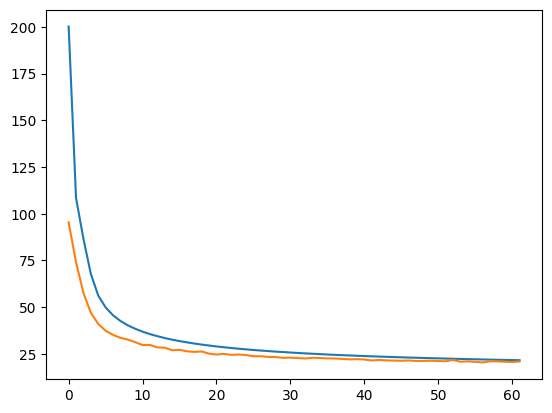

In [46]:
plt.plot(history.history['perplexity'])
plt.plot(history.history['val_perplexity'])

In [ ]:
# Load the TensorBoard notebook extension if available
%load_ext tensorboard

In [ ]:
%tensorboard --logdir $BASE_DIR/logs

## Inference with pre-trained model

In [ ]:
prompt_tokens = start_packer(tokenizer([""]))
prompt_tokens

Function to compute next token.

In [ ]:
def next(prompt, cache, index):
    logits = gpt(prompt)[:, index - 1, :]
    # Ignore hidden states for now
    hidden_states = None
    return logits, hidden_states, cache

### Test different kinds of samplers

In [ ]:
sampler = keras_hub.samplers.GreedySampler()
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,  # Start sampling immediately after the [BOS] token.
)
txt = tokenizer.detokenize(output_tokens)
print(f"Greedy search generated text: \n{txt}\n")

In [ ]:
sampler = keras_hub.samplers.BeamSampler(num_beams=2)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Beam search generated text: \n{txt}\n")

In [ ]:
sampler = keras_hub.samplers.TopKSampler(k=5, temperature=1.0)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-K search generated text: \n{txt}\n")

In [ ]:
sampler = keras_hub.samplers.TopPSampler(p=0.9, k=10, temperature=1.0)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=1,
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-P search generated text: \n{txt}\n")

In [ ]:
class TopKTextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model using top-k."""

    def __init__(self, k, temperature):
        self.sampler = keras_hub.samplers.TopKSampler(k=k, temperature=temperature)

    def on_epoch_end(self, epoch, logs=None):
        output_tokens = self.sampler(
            next=next,
            prompt=prompt_tokens,
            index=1,
        )
        txt = tokenizer.detokenize(output_tokens)
        print(f"\nTop-K search generated text: \n{txt}\n")


text_generation_callback = TopKTextGenerator(k=5, temperature=1.2)



In [ ]:
class TopPTextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model using top-p."""

    def __init__(self, p, k, temperature):
        self.sampler = keras_hub.samplers.TopPSampler(p=p, k=k, temperature=temperature)

    def on_epoch_end(self, epoch, logs=None):
        output_tokens = self.sampler(
            next=next,
            prompt=prompt_tokens,
            index=1,
        )
        txt = tokenizer.detokenize(output_tokens)
        print(f"\nTop-P search generated text: \n{txt}\n")


text_generation_callback = TopPTextGenerator(p=0.8, k=5, temperature=1.2)

### Optional: keep training with callbacks VERY SLOW

In [ ]:
# Dummy training loop to demonstrate callback.
gpt.fit(train_ds.take(1), verbose=1, epochs=1, callbacks=[text_generation_callback])

In [ ]:
# Training loop with callbacks
#gpt.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[earlystop, tensorboard, text_generation_callback])

In [ ]:
gpt.summary()

In [ ]:
gpt.save(BASE_DIR+'/models/pseudollam2-simplebooks-pt.keras')

## Instruction tuning
Read and preprocess Q&A dataset

In [ ]:
df = pd.read_parquet("hf://datasets/vicgalle/alpaca-gpt4/data/train-00000-of-00001-6ef3991c06080e14.parquet")
df.head()

In [ ]:
ds=tf_data.Dataset.from_tensor_slices(df["text"]).batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
ds

In [ ]:
ids=ds.map(preprocess, num_parallel_calls=tf_data.AUTOTUNE).prefetch(tf_data.AUTOTUNE)

In [ ]:
train_ids, val_ids=keras.utils.split_dataset(ids, left_size=0.8, shuffle=True, seed=SEED)

In [ ]:
for element in ds.take(1):
    print(element)

### Training loop

In [ ]:
text_generation_callback = TopKTextGenerator(k=5, temperature=1.0)

In [ ]:
# Training loop with callbacks
it_history= gpt.fit(train_ids,
                    validation_data=val_ids,
                    epochs=100,
                    callbacks=[earlystop,
                               #text_generation_callback, ## very slow so comment out
                               tensorboard],
                    verbose=1,
                   )

In [ ]:
plt.plot(it_history.history['perplexity'])
plt.plot(it_history.history['val_perplexity'])

In [ ]:
gpt.evaluate(val_ids)

In [ ]:
gpt.save(BASE_DIR+'/models/colmo-simplebooks-it.keras')

## Inference with I.T. model

In [ ]:
# Don't want to wait for jit every single time we call predict
gpt.jit_compile=False

In [ ]:
prompt_tokens = start_packer(tokenizer(["""Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.\n\n
Instruction:\nWrite a list of 3 ingredients for a sandwich.\n\n
Input:\nno ham\n\n
Response: """ ]))
prompt_tokens

In [ ]:
print (len(prompt_tokens[0]))

In [ ]:
np.where(np.array(prompt_tokens).flatten()==0)[0][0]

In [ ]:
sampler = keras_hub.samplers.TopPSampler(k=10,
                                         p=0.5,
                                         seed=SEED,
                                         temperature=1.0
)
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=np.where(np.array(prompt_tokens).flatten()==0)[0][0],
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-P search generated text: \n{txt}\n")

In [ ]:
prompt_tokens = start_packer(tokenizer(["""Below is an instruction that describes a task, paired with an input that provides further context.
Write a response that appropriately completes the request.\n\n
Instruction:\nWrite a short story about a fair maiden.\n\n
Input:\n no princes\n\n
Response: """ ]))
prompt_tokens

In [ ]:
output_tokens = sampler(
    next=next,
    prompt=prompt_tokens,
    index=np.where(np.array(prompt_tokens).flatten()==0)[0][0],
)
txt = tokenizer.detokenize(output_tokens)
print(f"Top-K search generated text: \n{txt}\n")